#Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [63]:
from torch.nn import CrossEntropyLoss

from torch.optim import AdamW

!pip install medmnist
!pip install torchinfo

In [64]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np


print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
NVIDIA GeForce RTX 3060 Ti
12.1


## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [65]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'organcmnist'
download = True

BATCH_SIZE = 256

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  1
Number of Classes =  11
The batch size for this dataset will be =  256


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [66]:

train_transforms = v2.Compose([
    v2.Resize((128,128)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# data


test_transforms = v2.Compose([
    v2.Resize((128,128)),
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


In [67]:
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=128, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=128, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=128, mmap_mode='r')


Using downloaded and verified file: /home/ibrahim/.medmnist/organcmnist_128.npz
Using downloaded and verified file: /home/ibrahim/.medmnist/organcmnist_128.npz
Using downloaded and verified file: /home/ibrahim/.medmnist/organcmnist_128.npz


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [68]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=4)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 128, 128])
Shape of y: torch.Size([256, 1]) torch.int64


Plot some example augmented images

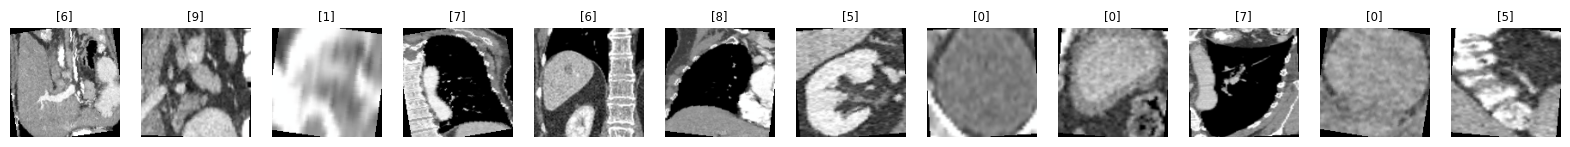

In [69]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [70]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [71]:
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, n_classes)
)
model = model.to(device)

writer = SummaryWriter('runs/my_experiment_1')

print(model)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [72]:
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
import time

loss_fn = CrossEntropyLoss()

# optimizer = torch.optim.AdamW(model.fc.parameters(), lr=0.001)

for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

scheduler = StepLR(optimizer,step_size=10,gamma=0.5)

epoch = 50


for i in range(epoch):
    start = time.perf_counter()

    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # ---- TRAINING ----
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = torch.squeeze(labels).to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        running_loss += loss.item()

        preds = torch.argmax(outputs,dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_acc = running_correct / running_total


    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / len(val_dataloader)
    val_acc = val_correct / val_total

    scheduler.step()

    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Accuracy/train", train_acc, i)
    writer.add_scalar("Accuracy/val", val_acc, i)

    end = time.perf_counter()


    print(f"Epoch {i+1}/{epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Elapsed: {end - start:.2f}s")


Epoch 1/50, Train Loss: 0.6898, Val Loss: 0.2215, Elapsed: 8.58s
Epoch 2/50, Train Loss: 0.1938, Val Loss: 0.0782, Elapsed: 8.01s
Epoch 3/50, Train Loss: 0.1168, Val Loss: 0.0643, Elapsed: 8.01s
Epoch 4/50, Train Loss: 0.0804, Val Loss: 0.0482, Elapsed: 8.01s
Epoch 5/50, Train Loss: 0.0629, Val Loss: 0.0493, Elapsed: 8.28s
Epoch 6/50, Train Loss: 0.0589, Val Loss: 0.0488, Elapsed: 9.40s
Epoch 7/50, Train Loss: 0.0436, Val Loss: 0.0609, Elapsed: 8.82s
Epoch 8/50, Train Loss: 0.0362, Val Loss: 0.0521, Elapsed: 8.33s
Epoch 9/50, Train Loss: 0.0276, Val Loss: 0.0555, Elapsed: 9.13s
Epoch 10/50, Train Loss: 0.0287, Val Loss: 0.0472, Elapsed: 8.67s
Epoch 11/50, Train Loss: 0.0215, Val Loss: 0.0489, Elapsed: 8.48s
Epoch 12/50, Train Loss: 0.0162, Val Loss: 0.0479, Elapsed: 9.40s
Epoch 13/50, Train Loss: 0.0163, Val Loss: 0.0480, Elapsed: 8.10s
Epoch 14/50, Train Loss: 0.0121, Val Loss: 0.0403, Elapsed: 8.27s
Epoch 15/50, Train Loss: 0.0121, Val Loss: 0.0419, Elapsed: 8.15s
Epoch 16/50, Train 

In [73]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1107901), started 0:56:44 ago. (Use '!kill 1107901' to kill it.)

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



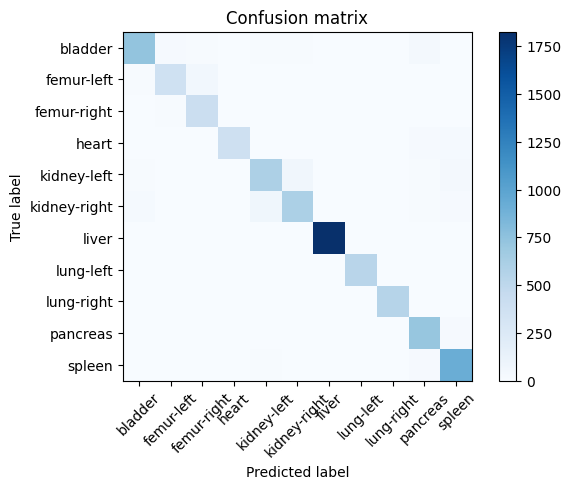

In [74]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix, accuracy_score

model.eval()
y_true = []
y_pred = []
classes = list(info['label'].values())

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.squeeze().to(device)

        outputs = model(images)

        predicted = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [75]:
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_true,y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_true, y_pred, target_names=classes))

Accuracy: 0.9273
              precision    recall  f1-score   support

     bladder       0.92      0.88      0.90       828
  femur-left       0.89      0.85      0.87       431
 femur-right       0.84      0.95      0.89       421
       heart       0.98      0.89      0.93       421
 kidney-left       0.85      0.82      0.84       727
kidney-right       0.88      0.82      0.85       735
       liver       0.99      1.00      0.99      1835
   lung-left       0.99      0.97      0.98       549
  lung-right       0.99      0.98      0.99       557
    pancreas       0.89      0.96      0.92       750
      spleen       0.90      0.96      0.93       962

    accuracy                           0.93      8216
   macro avg       0.92      0.92      0.92      8216
weighted avg       0.93      0.93      0.93      8216



# Comments About My Approach

## Batch Size Selection
I experimented with a range of batch sizes — **32, 64, 128, and 256** — to observe how they influenced both training stability and convergence.

- Smaller batch sizes produced **noisier validation curves** and slower convergence due to higher gradient variance.
- Larger batch sizes gave **smoother training curves** and more stable validation accuracy.

I ultimately chose **256** because it:
- Provided the most consistent and stable performance
- Made efficient use of the GPU
- Reduced randomness in both training and validation metrics

---

## Image Transforms

To prepare the data and improve generalisation, I used the following transforms:

### `Resize((128, 128))`
ResNet18 was pretrained on larger spatial dimensions.
I chose **128×128** because:
- It retains important features for learning
- Reduces computation compared to 224×224
- Still allowed the model to achieve high accuracy efficiently

### `RandomRotation(10)`
RandomRotation(10): This augmentation helped the model generalise to organs appearing in slightly different orientations, allowing the model to adapt to natural variability in organ positioning.


### `RandomHorizontalFlip()`
This prevents the model from memorising fixed orientations and improves generalisation.

## Optimizer & Learning Strategy

I used **AdamW**, combined with a **differential learning rate** setup:

- **Low LR (1e-4)** for fine-tuning `layer4`
- **Higher LR (1e-3)** for the new classifier head

This allowed the pretrained layers to adjust slowly while letting the new fully connected layers learn quickly.

I also added a **StepLR scheduler**, reducing the learning rate every 10 epochs.
This improved stability in later training stages and reduced fluctuations in validation accuracy.

---


## Model Choice & Benchmark Comparison

I chose **ResNet-18** because it is lightweight, widely used for transfer learning, and performs well on small medical imaging datasets like MedMNIST. Its pretrained ImageNet features transfer effectively while still being fast to fine-tune.

For the OrganCMNIST dataset, the official MedMNIST benchmark reports:
- **ResNet-18 (224×224)** accuracy: **~0.90**
- **ResNet-18 (28×28)** accuracy: **~0.90**

In my experiments, I achieved a validation accuracy of **≈93%**, which is **slightly above the reported ResNet-18 baseline**.
This indicates that:
- my training setup (image size 128, augmentations, LR strategy) generalised well
- the model is performing at a level comparable to published benchmarks, if not slightly better

Overall, the results show successful transfer learning and strong generalisation on OrganCMNIST.


## Issues Faced

I initially had issues enabling GPU acceleration due to a CUDA version mismatch with my RTX 3060 Ti. After installing the correct CUDA setup, I saw immediate improvements:

- Training became significantly faster
- I was able to increase input size from **64×64** to **128×128**
- This improved the model's ability to learn meaningful features

Once GPU training was working, overall performance and convergence improved noticeably.

